In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *
import json
from urllib.error import URLError,HTTPError
import time
from pathlib import Path

In [3]:
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    print(f'searching for {term}')
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]

In [8]:
# create DIR for notebook and set current DIR
NOTEBOOK_DIR = "Deployment"
Path(NOTEBOOK_DIR).mkdir(parents=True, exist_ok=True)

searching for grizzly bear


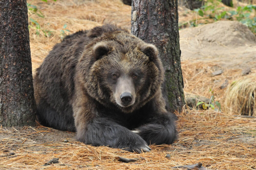

In [9]:
from fastdownload import download_url
from fastai.vision.all import *

dest = NOTEBOOK_DIR + '/grizzly_bear.jpg'
urls = search_images_ddg("grizzly bear", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

searching for plane photos


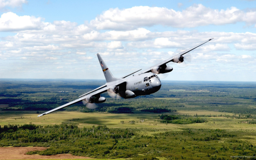

In [12]:
dest = NOTEBOOK_DIR + '/plane.jpg'
urls = search_images_ddg("plane photos", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

searching for bus photos


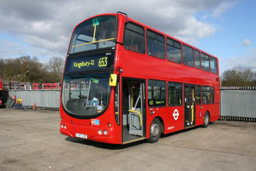

In [21]:
dest = NOTEBOOK_DIR + '/bus.jpg'
urls = search_images_ddg("bus photos", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

In [10]:
searches = ['grizzly', 'black', 'teddy']
path = Path(NOTEBOOK_DIR+'/images')

for search in searches:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{search} bear', max_images=30))
    time.sleep(10)
    resize_images(dest, max_size=400, dest=dest)
    
    
    

searching for grizzly bear
searching for black bear
searching for teddy bear


In [17]:
# remove failed images

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

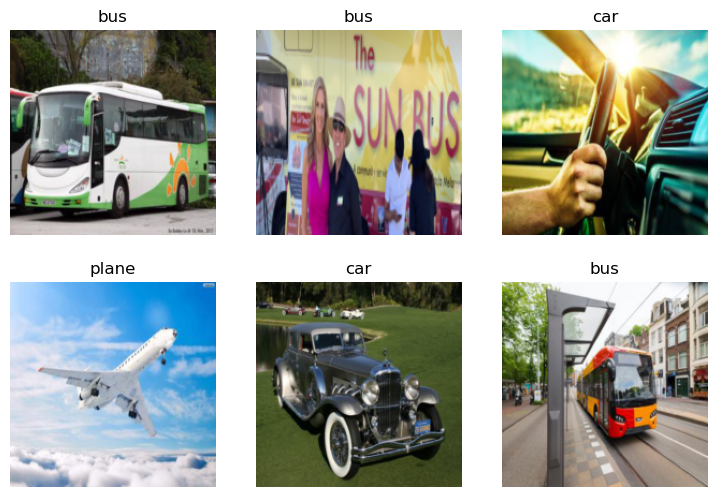

In [18]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)


In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.489358,0.264400,0.074074,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.196348,0.101775,0.037037,00:14
1,0.135613,0.012122,0.000000,00:14
2,0.097726,0.009820,0.000000,00:15


In [49]:
def get_output(file_name):
    label,index,probs = learn.predict(PILImage.create(NOTEBOOK_DIR + f'/{file_name}'))
    print(index)
    print(f"This is a {label}.")
    print(f"Probability it's a bus: {probs[0]:.4f}")
    print(f"Probability it's a car: {probs[1]:.4f}")
    print(f"Probability it's a plane: {probs[2]:.4f}")

In [52]:
get_output('bus.jpg')

TensorBase(0)
This is a bus.
Probability it's a bus: 1.0000
Probability it's a car: 0.0000
Probability it's a plane: 0.0000


searching for forest photos


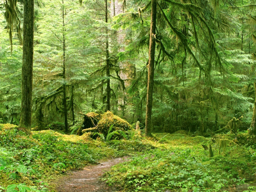

In [40]:
# cross test

dest = NOTEBOOK_DIR + '/forest.jpg'
urls = search_images_ddg("forest photos", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

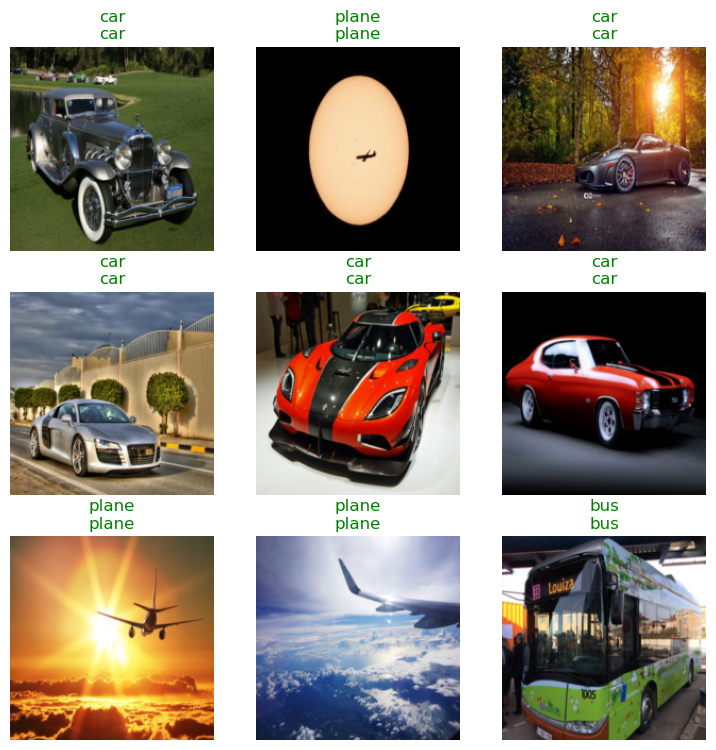

In [55]:
learn.show_results()